In [1]:
%matplotlib inline

In [2]:
import os
os.chdir(r'C:\Users\Public\Downloads')

In [3]:
import palom
print(palom.__version__)

2023.8.2


In [4]:
r1 = palom.reader.OmePyramidReader('VGP_cycle1_ROI1.ome.tif')
r2 = palom.reader.OmePyramidReader('VGP_cycle2_ROI1.ome.tif')
r3 = palom.reader.OmePyramidReader('VGP_cycle3_ROI1.ome.tif')

2023-09-06 15:45:26.065 | WARNING  | palom.reader:auto_format_pyramid:64 - Unable to detect pyramid levels, it may take a while to compute thumbnails during coarse alignment
2023-09-06 15:45:26.899 | WARNING  | palom.reader:auto_format_pyramid:64 - Unable to detect pyramid levels, it may take a while to compute thumbnails during coarse alignment
2023-09-06 15:45:27.889 | WARNING  | palom.reader:auto_format_pyramid:64 - Unable to detect pyramid levels, it may take a while to compute thumbnails during coarse alignment


In [5]:
r1.pyramid

[dask.array<astype, shape=(6, 4106, 25887), dtype=uint8, chunksize=(1, 256, 256), chunktype=numpy.ndarray>,
 dask.array<astype, shape=(6, 2053, 12943), dtype=uint8, chunksize=(1, 128, 128), chunktype=numpy.ndarray>,
 dask.array<astype, shape=(6, 1026, 6471), dtype=uint8, chunksize=(1, 64, 64), chunktype=numpy.ndarray>,
 dask.array<astype, shape=(6, 513, 3235), dtype=uint8, chunksize=(1, 32, 32), chunktype=numpy.ndarray>,
 dask.array<astype, shape=(6, 256, 1617), dtype=uint8, chunksize=(1, 16, 16), chunktype=numpy.ndarray>,
 dask.array<astype, shape=(6, 128, 808), dtype=uint8, chunksize=(1, 8, 8), chunktype=numpy.ndarray>]

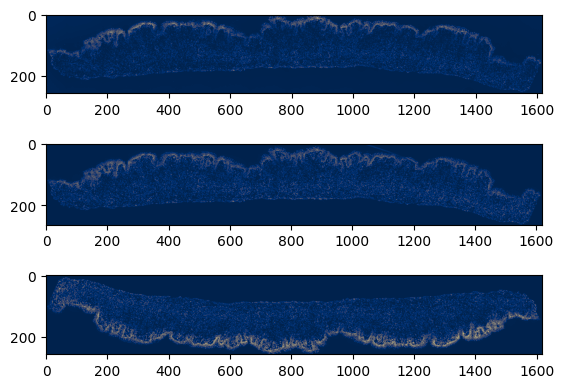

In [6]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 1)
for reader, ax in zip([r1, r2, r3], axs):
    ax.imshow(reader.pyramid[4][0], cmap='cividis')

[[211 210 210 210]
 [ 12  12  14  16]]
0 0


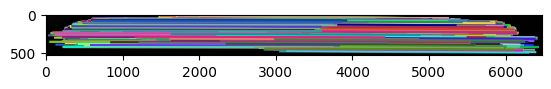

In [7]:
c21l = palom.align.get_aligner(r1, r2, thumbnail_level1=3, thumbnail_level2=3)
c21l.coarse_register_affine(n_keypoints=5_000, detect_flip_rotate=True)

[[122 120 125 124]
 [ 10  10  11  10]]
0 2


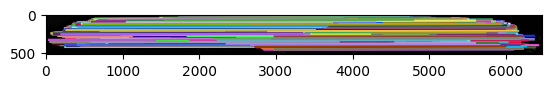

In [8]:
c31l = palom.align.get_aligner(r1, r3, thumbnail_level1=3, thumbnail_level2=3)
c31l.coarse_register_affine(n_keypoints=5_000, detect_flip_rotate=True)


2023-09-06 15:46:23.848 | INFO     | palom.align:compute_shifts:195 - Computing block-wise shifts


Computing shifts:   0%|          | 0/15607 [00:00<?, ?it/s]

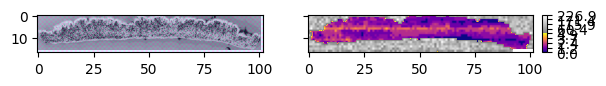

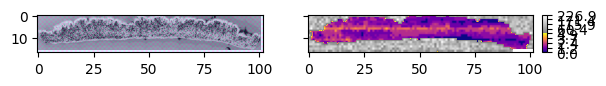

In [9]:
c21l.compute_shifts()
c21l.constrain_shifts()
c21l.ref_thumbnail = c21l.ref_thumbnail.compute()
c21l.plot_shifts()

2023-09-06 15:46:42.036 | INFO     | palom.align:compute_shifts:195 - Computing block-wise shifts


Computing shifts:   0%|          | 0/15607 [00:00<?, ?it/s]

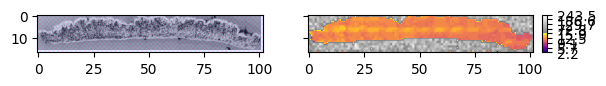

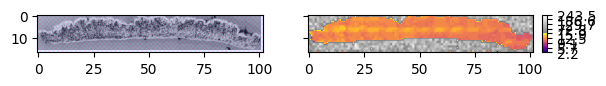

In [10]:
c31l.compute_shifts()
c31l.constrain_shifts()
c31l.ref_thumbnail = c31l.ref_thumbnail.compute()
c31l.plot_shifts()

In [11]:
mosaics = [r1.pyramid[0][0]]
for aligner, reader in zip([c21l, c31l], [r2, r3]):
    mosaics.append(
        palom.align.block_affine_transformed_moving_img(
            aligner.ref_img,
            reader.pyramid[0][0],
            aligner.block_affine_matrices_da)
    )

In [12]:
palom.pyramid.write_pyramid(
    mosaics,
    'registered-VGP.ome.tif',
    r1.pixel_size,
    downscale_factor=2,
    compression='lzw',
    tile_size=1024,
    save_RAM=True
)

2023-09-06 15:47:02.563 | INFO     | palom.reader:pixel_size:167 - Detected pixel size: 0.2495 µm
2023-09-06 15:47:02.576 | INFO     | palom.pyramid:write_pyramid:167 - Writing to registered-VGP.ome.tif


Assembling mosaic  1/ 3 (channel  1/ 1):   0%|          | 0/6937 [00:00<?, ?it/s]

Assembling mosaic  2/ 3 (channel  1/ 1):   0%|          | 0/10406 [00:00<?, ?it/s]

Assembling mosaic  3/ 3 (channel  1/ 1):   0%|          | 0/10406 [00:00<?, ?it/s]

2023-09-06 15:47:27.492 | INFO     | palom.pyramid:write_pyramid:186 - Generating pyramid
2023-09-06 15:47:27.492 | INFO     | palom.pyramid:write_pyramid:191 -     Level 1 (2053 x 12944)
Processing channel: 100%|##########| 3/3 [00:01<00:00,  2.18it/s]
2023-09-06 15:47:28.901 | INFO     | palom.pyramid:write_pyramid:191 -     Level 2 (1027 x 6472)
Processing channel: 100%|##########| 3/3 [00:00<00:00,  6.00it/s]
2023-09-06 15:47:29.416 | INFO     | palom.pyramid:write_pyramid:191 -     Level 3 (514 x 3236)
Processing channel: 100%|##########| 3/3 [00:00<00:00, 11.38it/s]
2023-09-06 15:47:29.706 | INFO     | palom.pyramid:write_pyramid:191 -     Level 4 (257 x 1618)
Processing channel: 100%|##########| 3/3 [00:00<00:00, 17.01it/s]
2023-09-06 15:47:29.907 | INFO     | palom.pyramid:write_pyramid:191 -     Level 5 (129 x 809)
Processing channel: 100%|##########| 3/3 [00:00<00:00, 25.16it/s]


In [13]:
import napari

v = napari.Viewer()
reader = palom.reader.OmePyramidReader('registered-VGP.ome.tif')

v.add_image(reader.pyramid, channel_axis=0)

[<Image layer 'Image' at 0x143d5905210>,
 <Image layer 'Image [1]' at 0x1438e05afb0>,
 <Image layer 'Image [2]' at 0x1438e05b0a0>]